In [1]:
# %matplotlib widget

import os
import numpy as np
import pandas as pd
import itertools as it
from glob import glob
import matplotlib.pyplot as plt
from sbpy.calib import Sun
from astropy import units as u
from astropy.io import fits

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from astropy.visualization import ImageNormalize, PercentileInterval, AsinhStretch

from lvmdrp.core.constants import LVM_UNAM_URL
from lvmdrp.utils.examples import fetch_example_data, get_frames_metadata, fix_lamps_metadata, get_masters_metadata

from lvmdrp.core import rss, image, spectrum1d
from lvmdrp.functions import imageMethod, rssMethod, fluxCalMethod

plt.style.use("seaborn-v0_8-talk")

In [2]:
# define input data directory
data_path = os.path.abspath(os.path.join("..", "data"))

# let's create the output directory
output_path = "./data"
os.makedirs(output_path, exist_ok=True)

# create processed frames path template
out_main_path = os.path.join(output_path, "lvm-{kind}-{camera}-{expnum}.fits")
out_calib_path = os.path.join(output_path, "lvm-{mjd}-{kind}-{camera}-{exptime}.fits")

In [3]:
# extract metadata
frames_table = get_frames_metadata(path=os.path.join(data_path, "lco_com"), ignore_cache=False).to_pandas()
frames_table = frames_table.loc[~frames_table.mjd.isin([60008,60009,60037,60038])]
# fix arc lamps metadata
fix_lamps_metadata(metadata=frames_table, lamp_names="argon neon ldls hgne xenon krypton".split())

# get master calibration metadata
masters_fiberflat = get_masters_metadata(path_pattern=out_calib_path, mjd="super", kind="mfiberflat", exptime="x").sort_values("camera")

[INFO]: loading cached metadata from '/home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/frames_table.pkl'


mjd                                        super
kind                                  mfiberflat
camera                                        b1
exptime                                        x
path       ./data/lvm-super-mfiberflat-b1-x.fits
Name: 5, dtype: object
[INFO]: selecting column = 3200 to locate fibers
[INFO]: locating fibers
[INFO]: found 638 fibers
[INFO]: refining fiber location
[INFO]: final number of fibers found 638


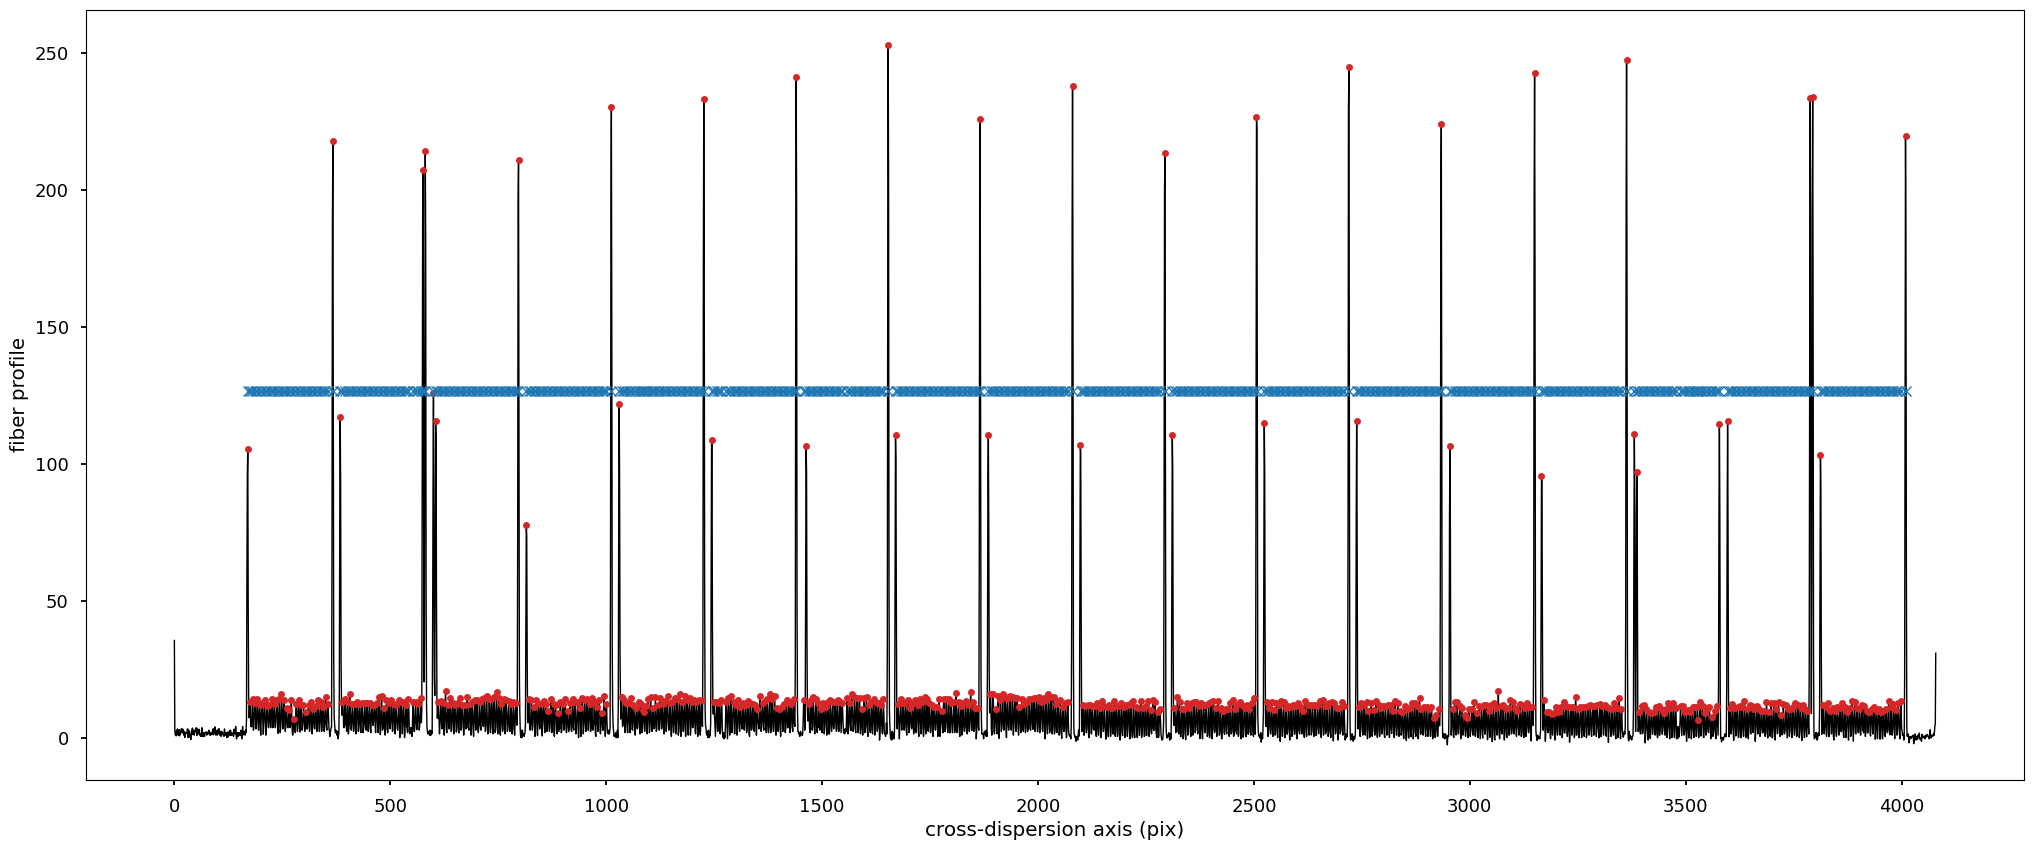

mjd                                        super
kind                                  mfiberflat
camera                                        b2
exptime                                        x
path       ./data/lvm-super-mfiberflat-b2-x.fits
Name: 8, dtype: object
[INFO]: selecting column = 3200 to locate fibers
[INFO]: locating fibers
[INFO]: found 638 fibers
[INFO]: refining fiber location
[INFO]: final number of fibers found 638


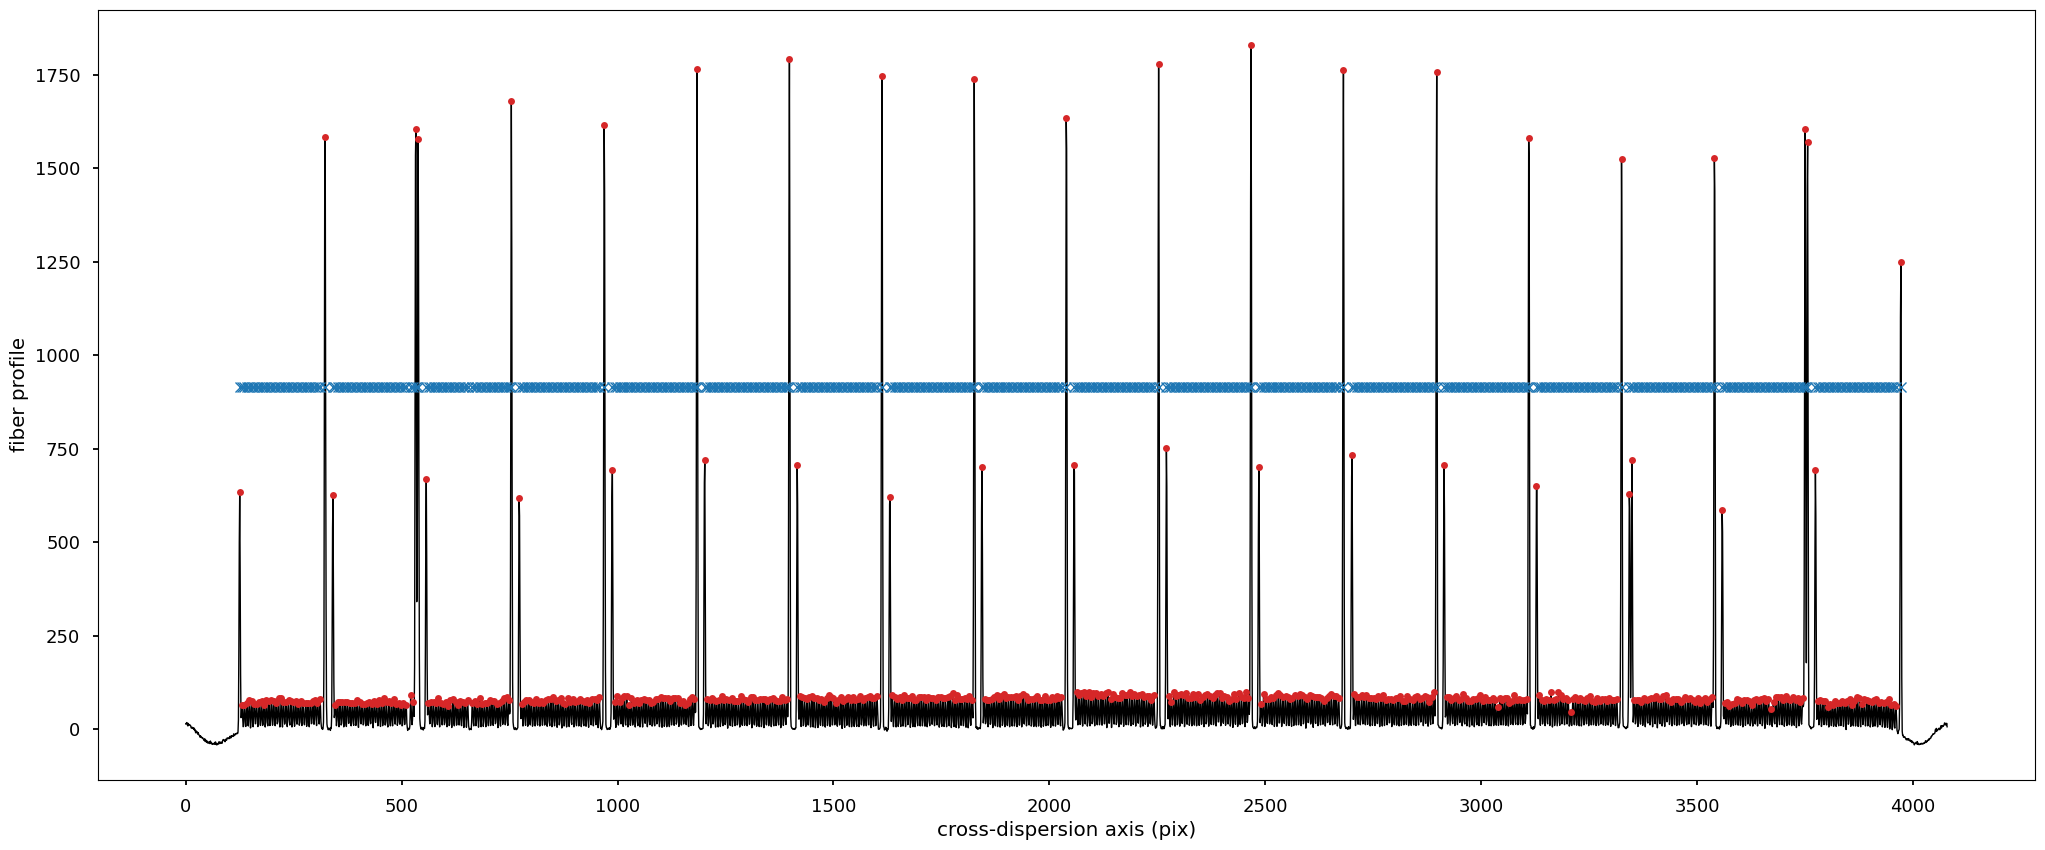

mjd                                        super
kind                                  mfiberflat
camera                                        b3
exptime                                        x
path       ./data/lvm-super-mfiberflat-b3-x.fits
Name: 6, dtype: object
[INFO]: selecting column = 3200 to locate fibers
[INFO]: locating fibers
[INFO]: found 638 fibers
[INFO]: refining fiber location
[INFO]: final number of fibers found 638


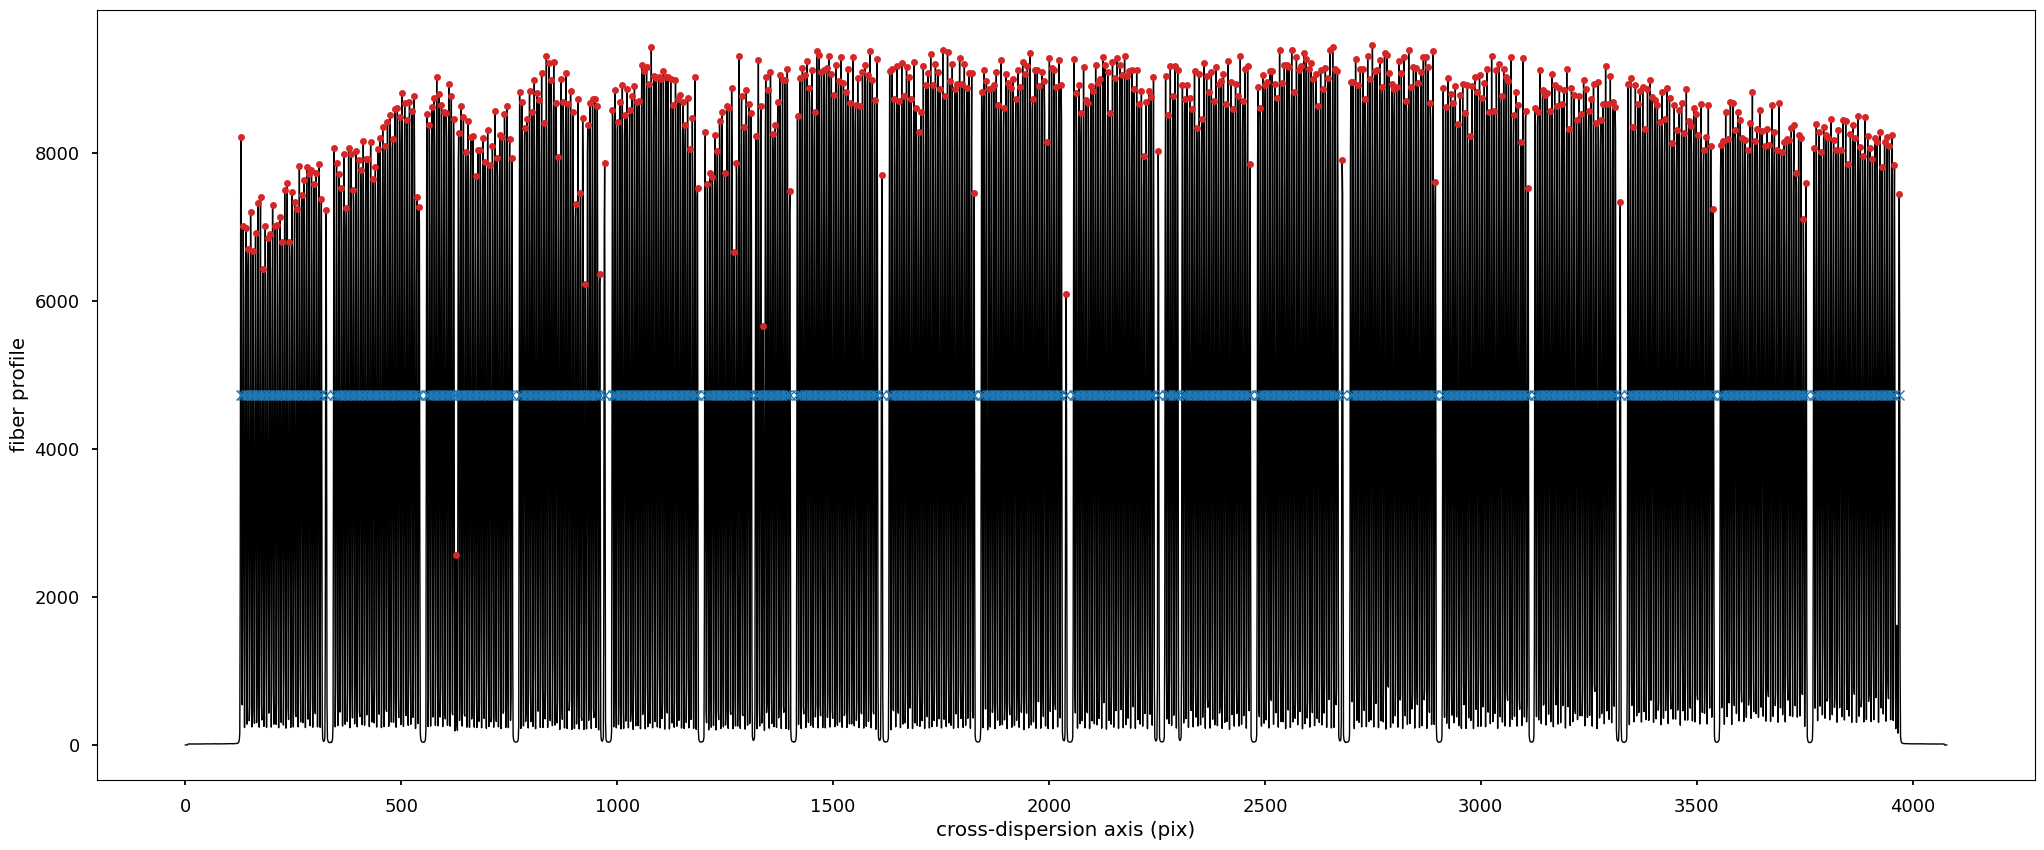

mjd                                        super
kind                                  mfiberflat
camera                                        r1
exptime                                        x
path       ./data/lvm-super-mfiberflat-r1-x.fits
Name: 4, dtype: object
[INFO]: selecting column = 3200 to locate fibers
[INFO]: locating fibers
[INFO]: found 638 fibers
[INFO]: refining fiber location
[INFO]: final number of fibers found 638


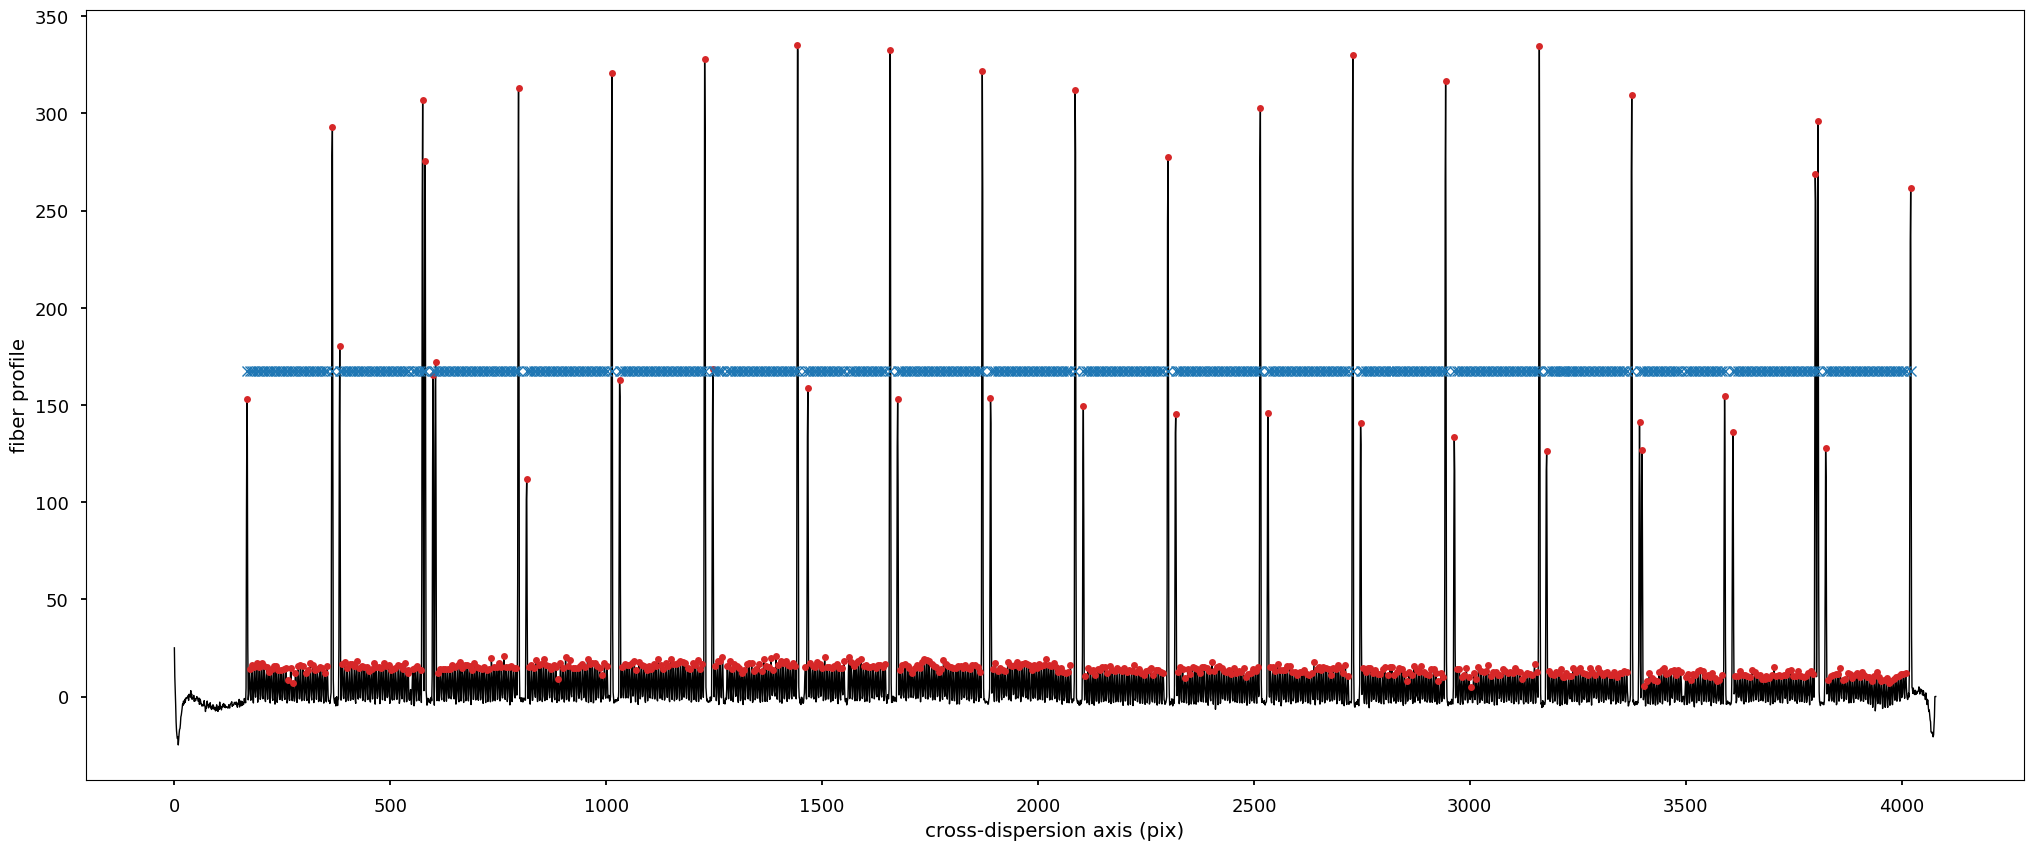

mjd                                        super
kind                                  mfiberflat
camera                                        r2
exptime                                        x
path       ./data/lvm-super-mfiberflat-r2-x.fits
Name: 7, dtype: object
[INFO]: selecting column = 3200 to locate fibers
[INFO]: locating fibers
[INFO]: found 638 fibers
[INFO]: refining fiber location
[INFO]: final number of fibers found 638


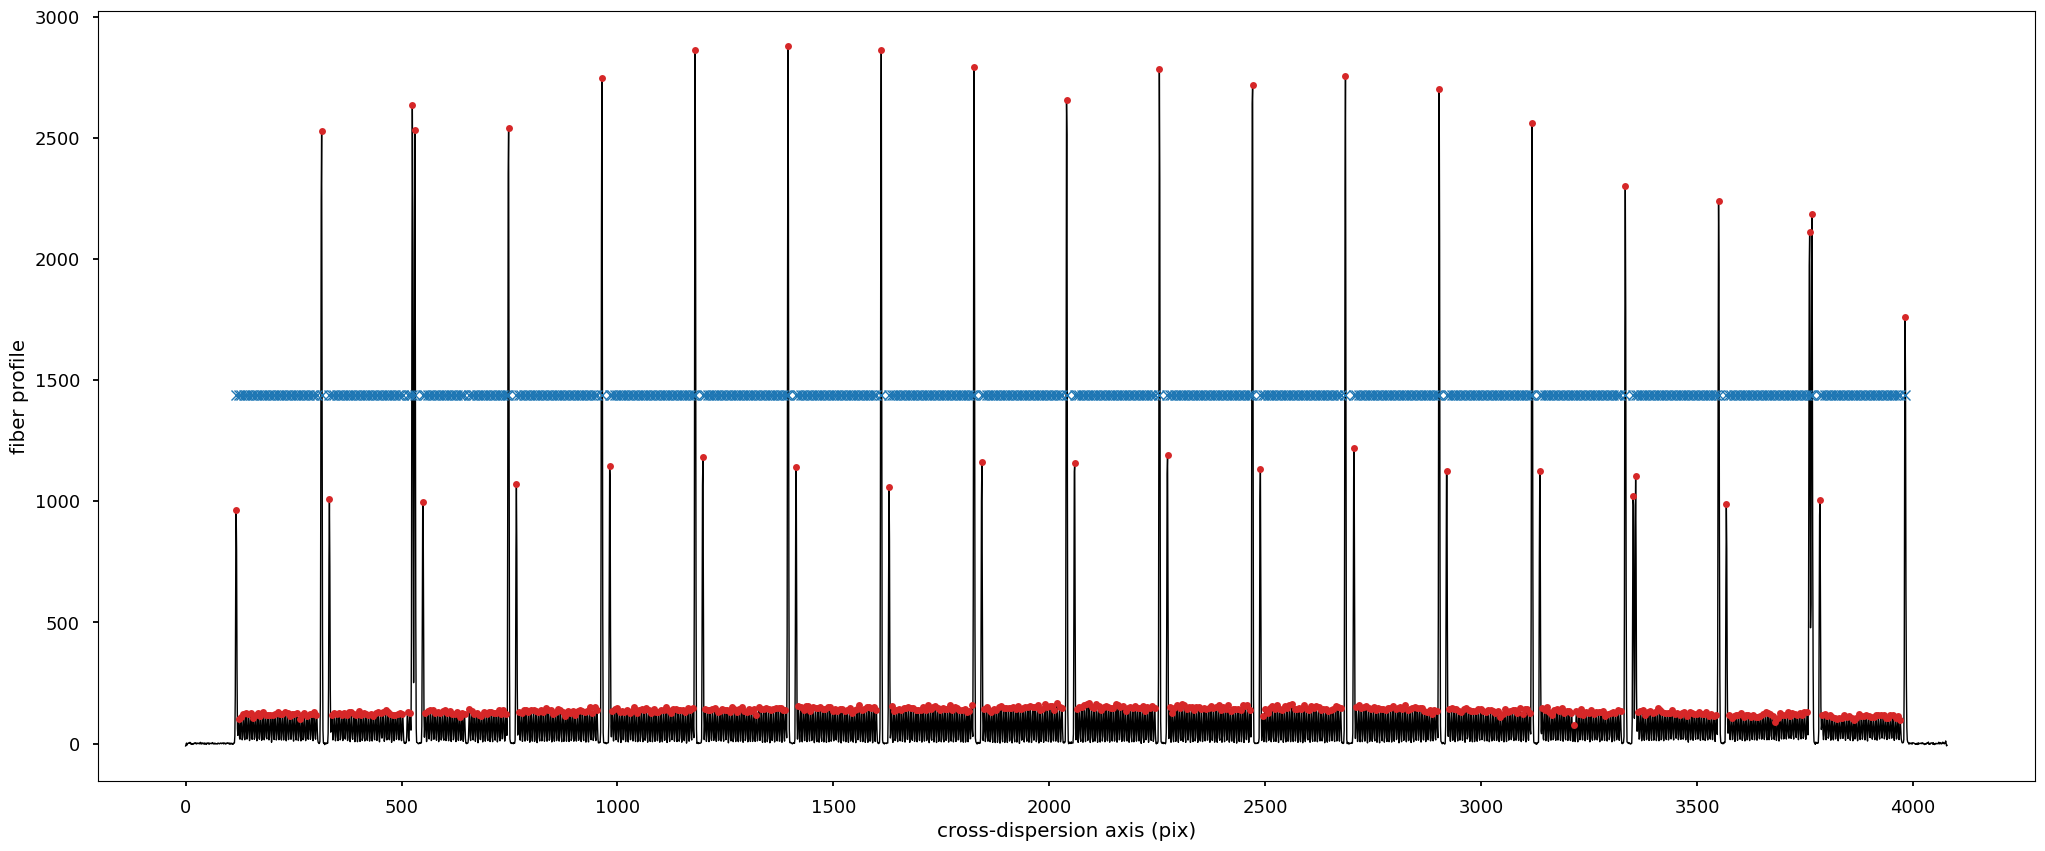

mjd                                        super
kind                                  mfiberflat
camera                                        r3
exptime                                        x
path       ./data/lvm-super-mfiberflat-r3-x.fits
Name: 3, dtype: object
[INFO]: selecting column = 3200 to locate fibers
[INFO]: locating fibers
[INFO]: found 638 fibers
[INFO]: refining fiber location
[INFO]: final number of fibers found 638


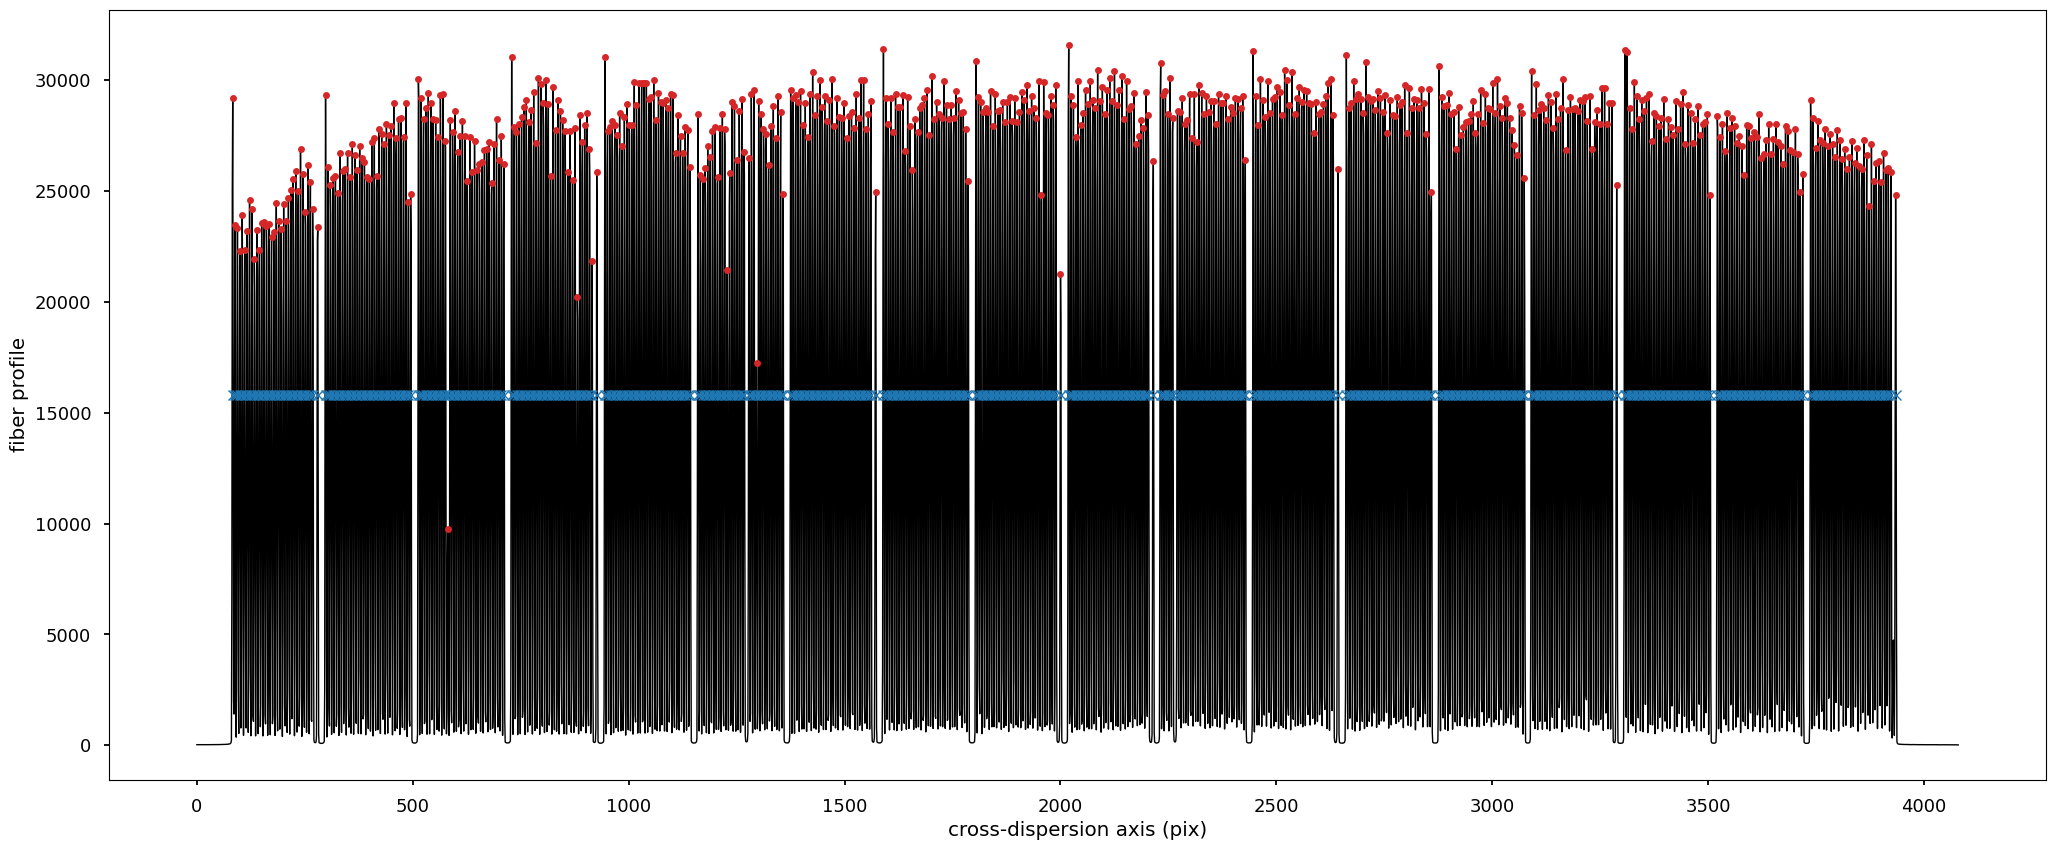

mjd                                        super
kind                                  mfiberflat
camera                                        z1
exptime                                        x
path       ./data/lvm-super-mfiberflat-z1-x.fits
Name: 0, dtype: object
[INFO]: selecting column = 3200 to locate fibers
[INFO]: locating fibers
[INFO]: found 638 fibers
[INFO]: refining fiber location
[INFO]: final number of fibers found 638


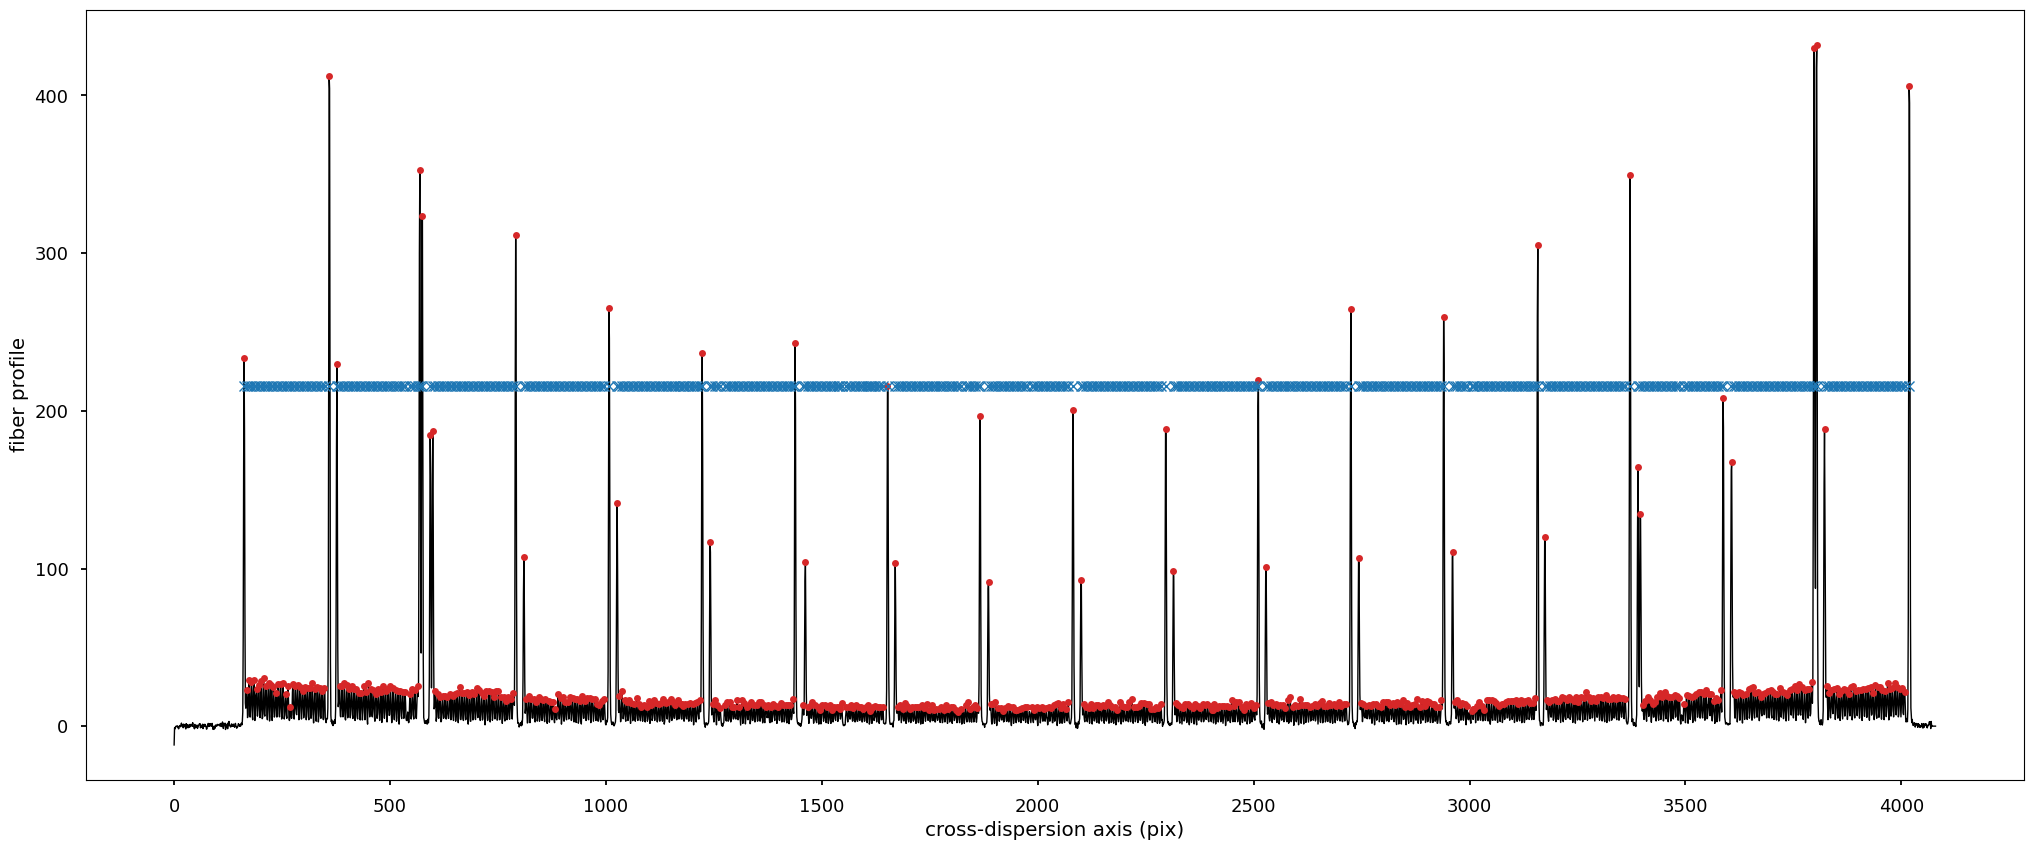

mjd                                        super
kind                                  mfiberflat
camera                                        z2
exptime                                        x
path       ./data/lvm-super-mfiberflat-z2-x.fits
Name: 2, dtype: object
[INFO]: selecting column = 3200 to locate fibers
[INFO]: locating fibers
[INFO]: found 638 fibers
[INFO]: refining fiber location
[INFO]: final number of fibers found 638


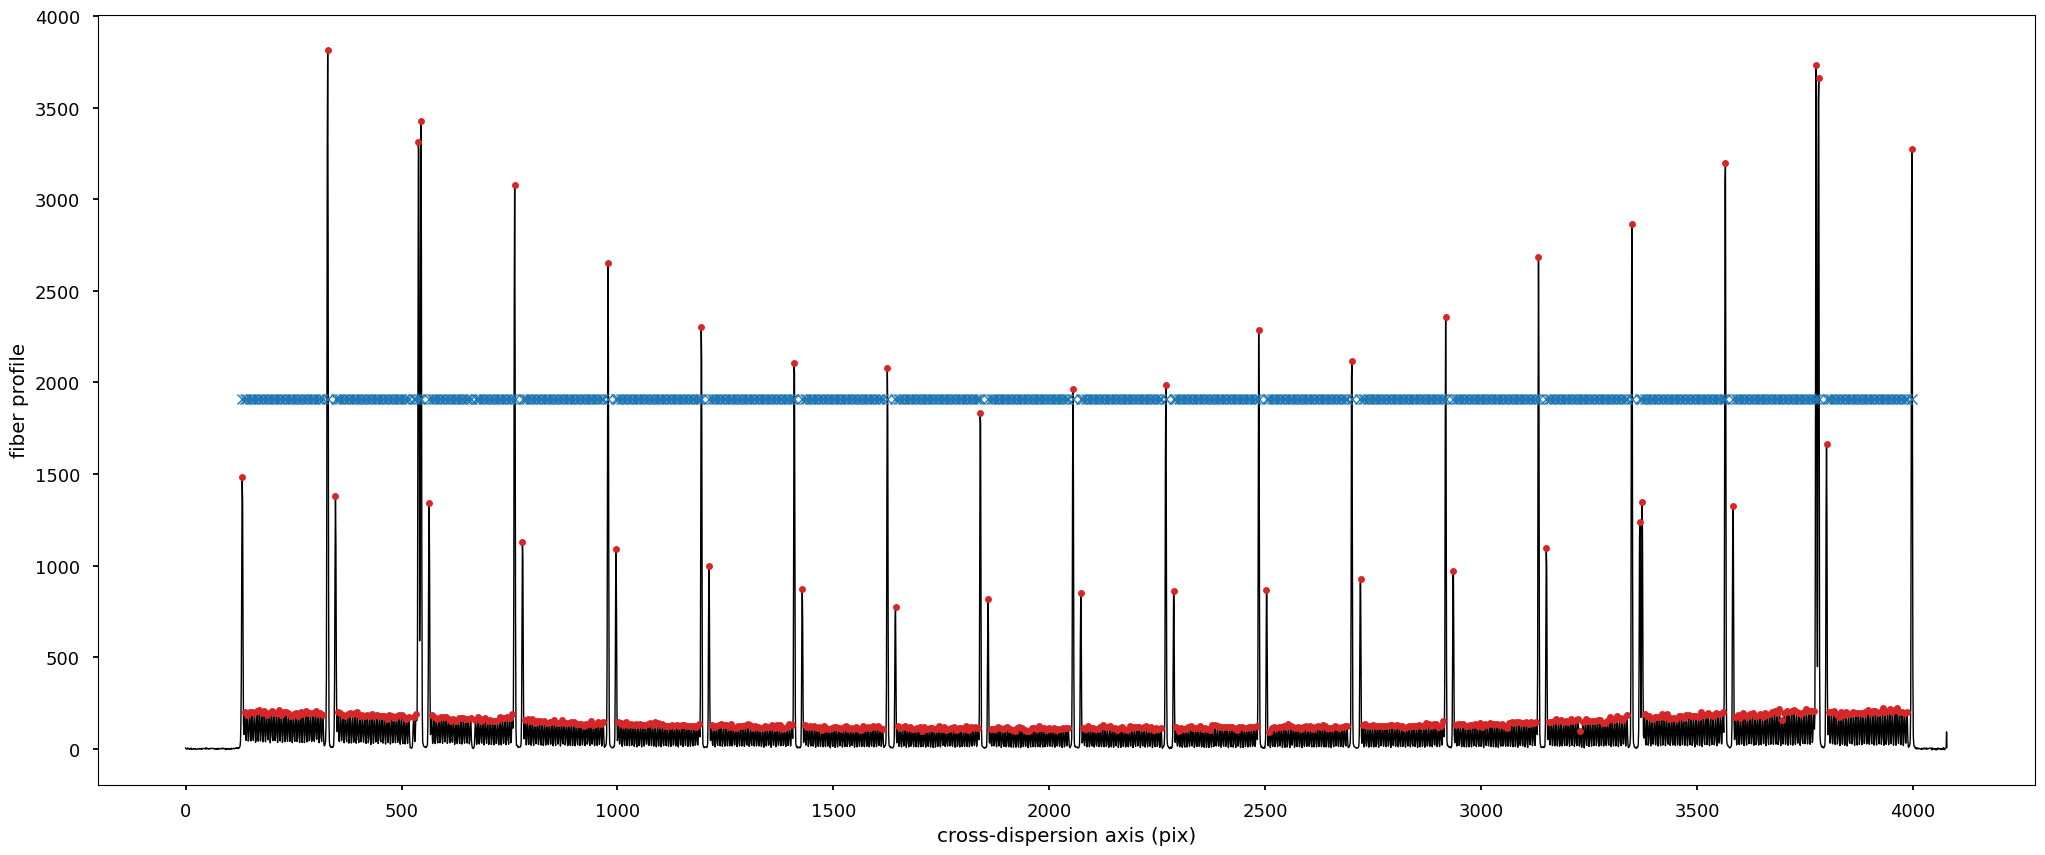

mjd                                        super
kind                                  mfiberflat
camera                                        z3
exptime                                        x
path       ./data/lvm-super-mfiberflat-z3-x.fits
Name: 1, dtype: object
[INFO]: selecting column = 3200 to locate fibers
[INFO]: locating fibers
[INFO]: found 638 fibers
[INFO]: refining fiber location
[INFO]: final number of fibers found 638


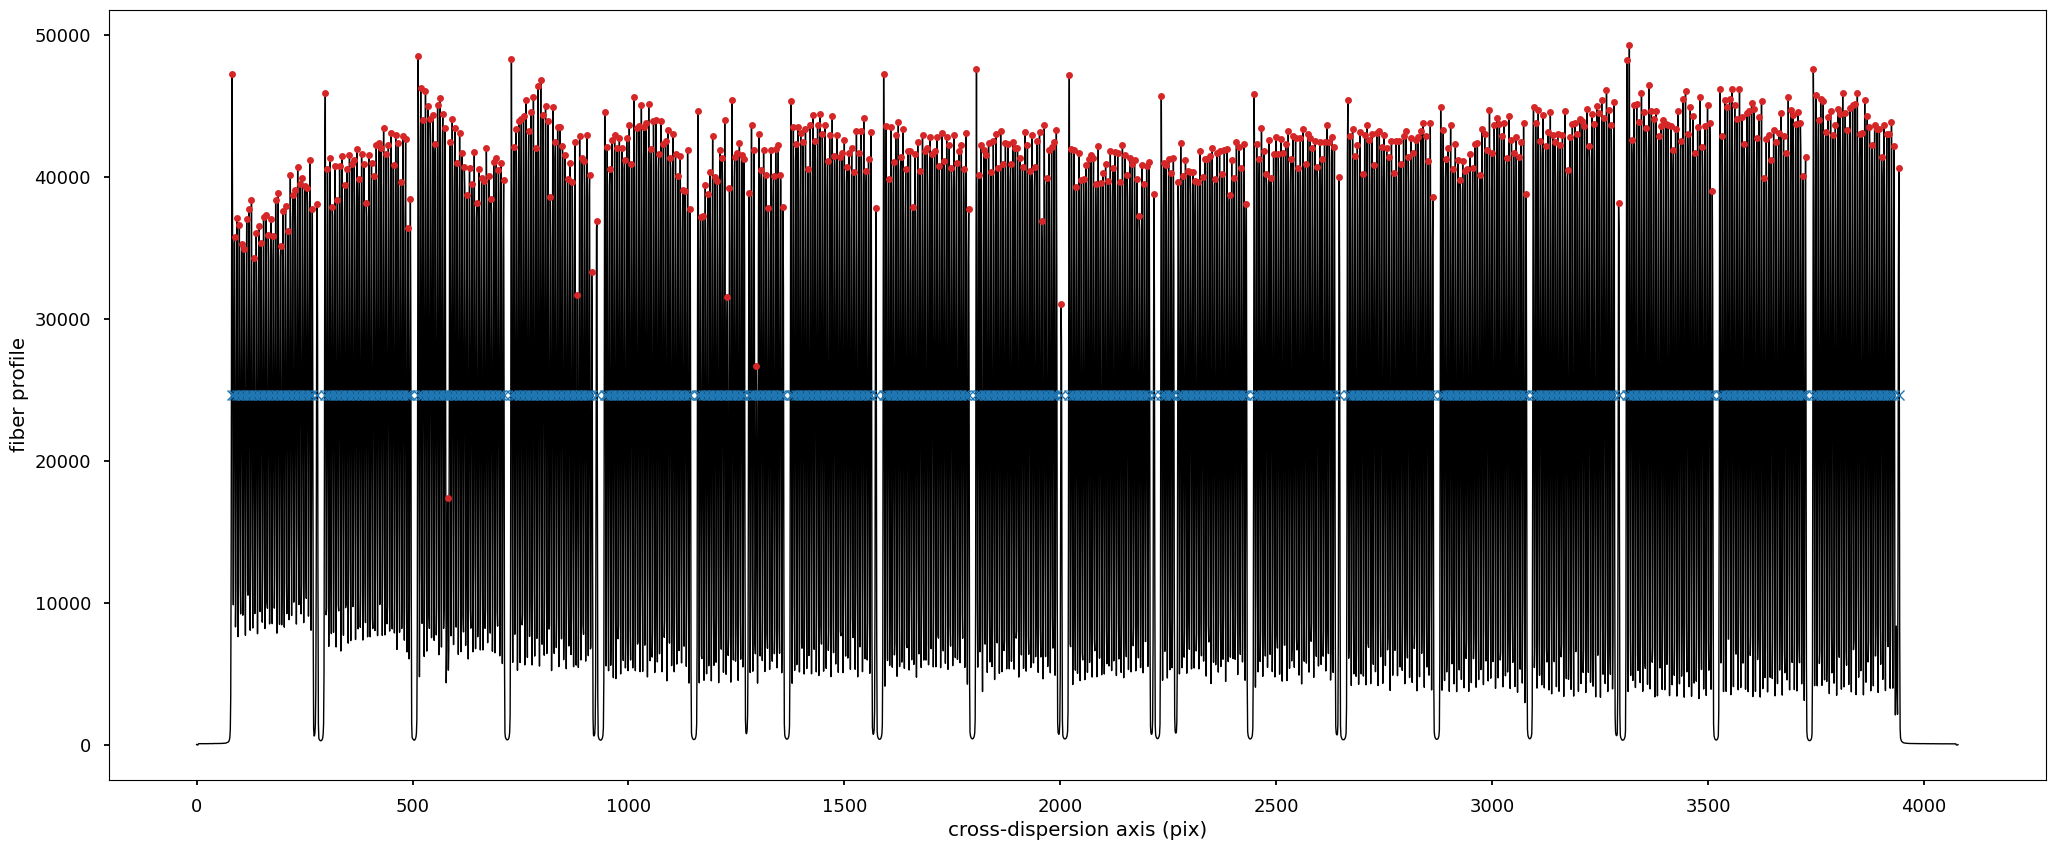

In [4]:
for _, mfiberflat in masters_fiberflat.iterrows():
    print(mfiberflat)
    
    try:
        imageMethod.findPeaksAuto_drp(
            in_image=mfiberflat.path,
            out_peaks=out_calib_path.format(mjd=mfiberflat.mjd, kind="mpeaks", camera=mfiberflat.camera, exptime=mfiberflat.exptime).replace(".fits", ".txt"),
            nfibers=638, slice=3200, threshold=0, method="hyperbolic", median_box=10, median_cross=1, plot=1
        )
    except ValueError:
        imageMethod.image_logger.error(f"error while detecting fibers in '{mfiberflat.path}'")
        continue

In [5]:
# avoid edges by one or two boxes before fitting the trace
for _, mfiberflat in masters_fiberflat.iterrows():
    print(mfiberflat)
    try:
        imageMethod.tracePeaks_drp(
            in_image=mfiberflat.path,
            out_trace=out_calib_path.format(mjd=mfiberflat.mjd, kind="mtrace", camera=mfiberflat.camera, exptime=int(mfiberflat.exptime) if mfiberflat.exptime != "x" else mfiberflat.exptime),
            in_peaks=out_calib_path.format(mjd=mfiberflat.mjd, kind="mpeaks", camera=mfiberflat.camera, exptime=int(mfiberflat.exptime) if mfiberflat.exptime != "x" else mfiberflat.exptime).replace(".fits", ".txt"),
            steps=30, coadd=1, threshold=0, max_diff=2, method="hyperbolic", median_box=10, median_cross=1, plot=1,
            poly_disp=2
        )
    except np.linalg.LinAlgError:
        imageMethod.image_logger.error(f"error while tracing fiberflat '{mfiberflat.path}'")
        continue

mjd                                        super
kind                                  mfiberflat
camera                                        b1
exptime                                        x
path       ./data/lvm-super-mfiberflat-b1-x.fits
Name: 5, dtype: object
[INFO]: tracing fibers along dispersion axis


tracing fiber left from pixel 3200:   2%|#2                                                            | 63/3200 [00:00<00:04, 629.75pixel/s]

[WARNING]: divide by zero encountered in divide (RuntimeWarning)
[WARNING]: invalid value encountered in divide (RuntimeWarning)


tracing fiber right from pixel 3200: 100%|#############################################################| 885/885 [00:01<00:00, 660.54pixel/s]


[INFO]: fitting trace with 2-deg polynomial
mjd                                        super
kind                                  mfiberflat
camera                                        b2
exptime                                        x
path       ./data/lvm-super-mfiberflat-b2-x.fits
Name: 8, dtype: object
[INFO]: tracing fibers along dispersion axis


tracing fiber right from pixel 3200: 100%|#############################################################| 885/885 [00:02<00:00, 388.68pixel/s]


[INFO]: fitting trace with 2-deg polynomial
mjd                                        super
kind                                  mfiberflat
camera                                        b3
exptime                                        x
path       ./data/lvm-super-mfiberflat-b3-x.fits
Name: 6, dtype: object
[INFO]: tracing fibers along dispersion axis


tracing fiber right from pixel 3200: 100%|#############################################################| 885/885 [00:02<00:00, 422.16pixel/s]


[INFO]: fitting trace with 2-deg polynomial
mjd                                        super
kind                                  mfiberflat
camera                                        r1
exptime                                        x
path       ./data/lvm-super-mfiberflat-r1-x.fits
Name: 4, dtype: object
[INFO]: tracing fibers along dispersion axis


tracing fiber right from pixel 3200: 100%|#############################################################| 885/885 [00:02<00:00, 398.40pixel/s]


[INFO]: fitting trace with 2-deg polynomial
mjd                                        super
kind                                  mfiberflat
camera                                        r2
exptime                                        x
path       ./data/lvm-super-mfiberflat-r2-x.fits
Name: 7, dtype: object
[INFO]: tracing fibers along dispersion axis


tracing fiber right from pixel 3200: 100%|#############################################################| 885/885 [00:02<00:00, 357.93pixel/s]


[INFO]: fitting trace with 2-deg polynomial
mjd                                        super
kind                                  mfiberflat
camera                                        r3
exptime                                        x
path       ./data/lvm-super-mfiberflat-r3-x.fits
Name: 3, dtype: object
[INFO]: tracing fibers along dispersion axis


tracing fiber right from pixel 3200: 100%|#############################################################| 885/885 [00:02<00:00, 431.43pixel/s]


[INFO]: fitting trace with 2-deg polynomial
mjd                                        super
kind                                  mfiberflat
camera                                        z1
exptime                                        x
path       ./data/lvm-super-mfiberflat-z1-x.fits
Name: 0, dtype: object
[INFO]: tracing fibers along dispersion axis


tracing fiber right from pixel 3200: 100%|#############################################################| 885/885 [00:02<00:00, 395.38pixel/s]


[INFO]: fitting trace with 2-deg polynomial
mjd                                        super
kind                                  mfiberflat
camera                                        z2
exptime                                        x
path       ./data/lvm-super-mfiberflat-z2-x.fits
Name: 2, dtype: object
[INFO]: tracing fibers along dispersion axis


tracing fiber right from pixel 3200: 100%|#############################################################| 885/885 [00:01<00:00, 459.61pixel/s]


[INFO]: fitting trace with 2-deg polynomial
mjd                                        super
kind                                  mfiberflat
camera                                        z3
exptime                                        x
path       ./data/lvm-super-mfiberflat-z3-x.fits
Name: 1, dtype: object
[INFO]: tracing fibers along dispersion axis


tracing fiber right from pixel 3200: 100%|#############################################################| 885/885 [00:02<00:00, 402.21pixel/s]


[INFO]: fitting trace with 2-deg polynomial


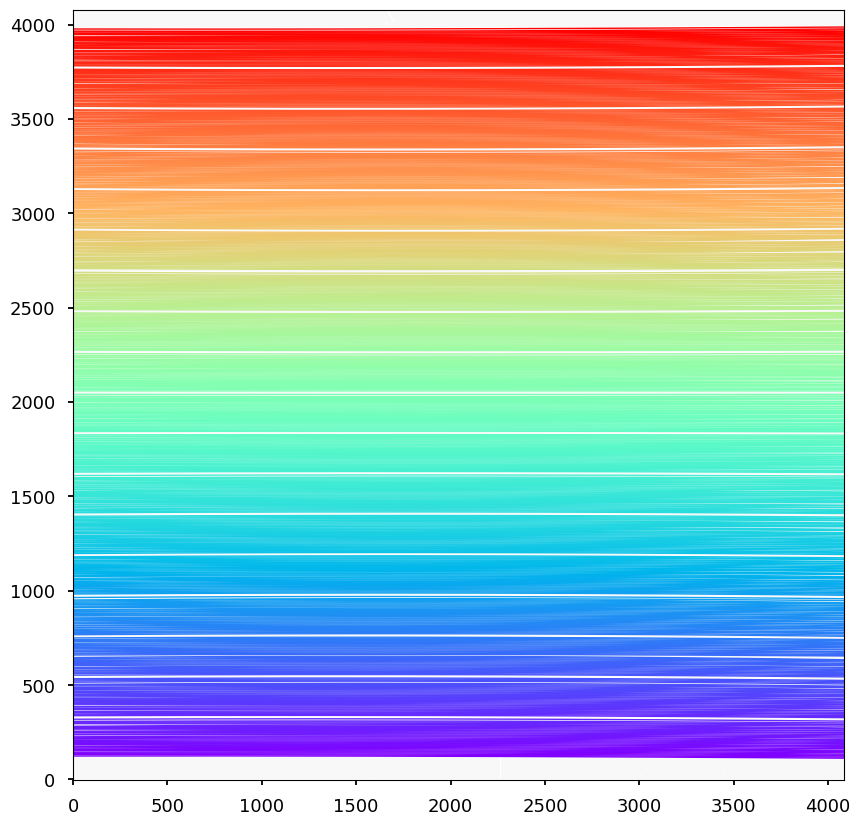

In [12]:
from lvmdrp.core import tracemask
from astropy.visualization import simple_norm

trace_path = out_calib_path.format(mjd="super", kind="mtrace", camera="r2", exptime="x")

trace = tracemask.TraceMask()
trace.loadFitsData(trace_path)

fiberflat = image.loadImage(trace_path.replace("mtrace", "mfiberflat"))

fiberflat_data = fiberflat._data
# fiberflat_data[fiberflat._mask] = np.nan

norm = simple_norm(fiberflat_data, stretch="log", max_percent=95)
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(fiberflat_data, norm=norm, origin="lower", cmap="binary_r")

for ifiber in range(trace._fibers):
    fiber = trace.getSpec(ifiber)
    ax.plot(fiber._pixels, fiber._data, color=plt.cm.rainbow(ifiber/trace._fibers), lw=1)

In [26]:
trace._pixels[[0,-1]]

array([   0, 4085])

In [31]:
peaks = np.loadtxt("data/lvm-super-mpeaks-r2-x.txt", skiprows=1)
peaks

array([[0.000000e+00, 1.170000e+02, 1.171435e+02, 0.000000e+00],
       [1.000000e+00, 1.230000e+02, 1.227217e+02, 0.000000e+00],
       [2.000000e+00, 1.290000e+02, 1.285614e+02, 0.000000e+00],
       ...,
       [6.350000e+02, 3.965000e+03, 3.965110e+03, 0.000000e+00],
       [6.360000e+02, 3.971000e+03, 3.970871e+03, 0.000000e+00],
       [6.370000e+02, 3.982000e+03, 3.982138e+03, 0.000000e+00]])

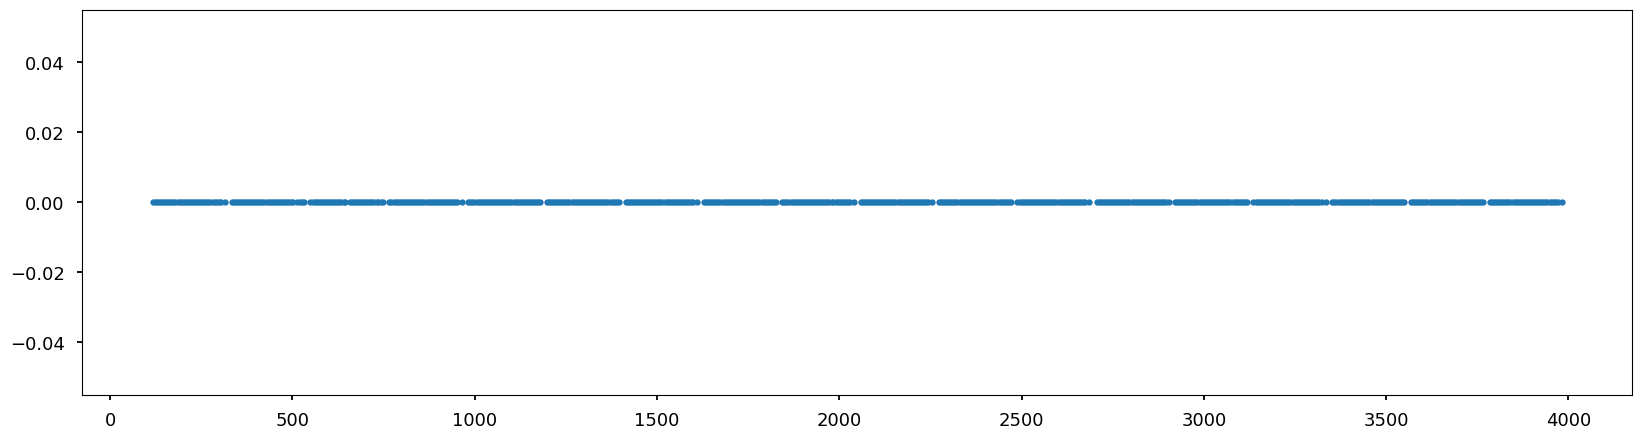

In [35]:
plt.figure(figsize=(20,5))
plt.plot(peaks[:,2], np.zeros_like(peaks[:,0]), ".")

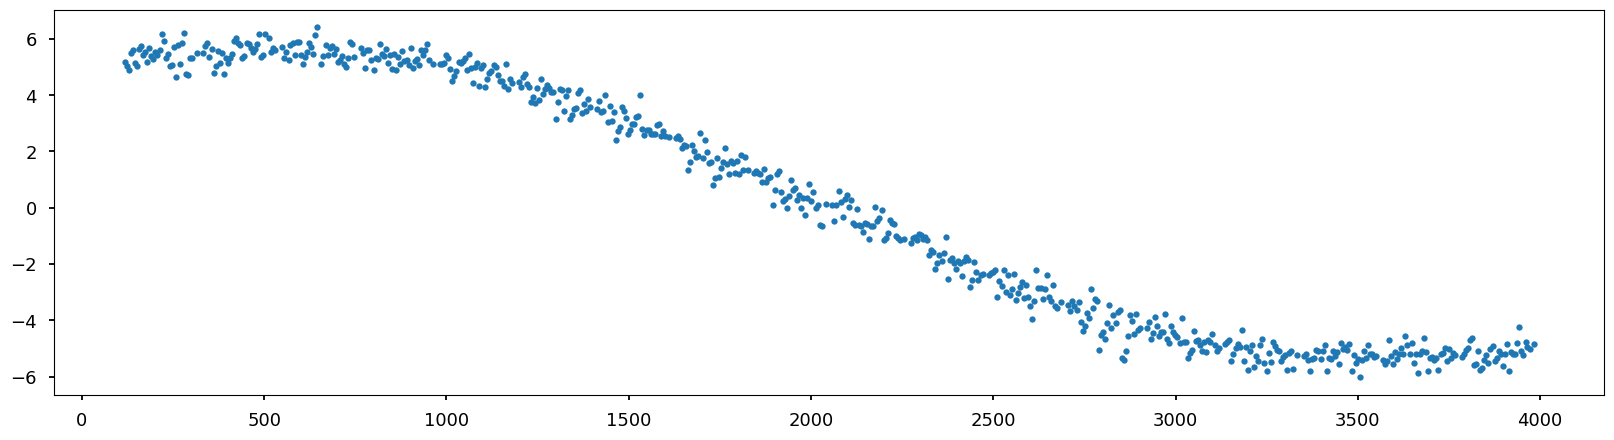

In [36]:
from numpy.polynomial import Polynomial

# poly = Polynomial(trace._coeffs[0], domain=trace._pixels[[0-1]].tolist())

# poly(trace._pixels), trace._data

plt.figure(figsize=(20,5))

icoef = 0
mlinear = Polynomial.fit(peaks[:,2], trace._coeffs[:, icoef], deg=1)
plt.plot(peaks[:,2], trace._coeffs[:, icoef] - peaks[:,2], ".")


In [6]:
master_traces = get_masters_metadata(path_pattern=out_calib_path, mjd="super", kind="mtrace", exptime="x")
print(master_traces.to_string())

for _, mfiberflat in masters_fiberflat.iterrows():
    print(mfiberflat)
    master_trace = master_traces.query("camera==@mfiberflat.camera")
    try:
        mtrace = master_trace.iloc[0]
    except:
        imageMethod.image_logger.error(f"no master trace found for '{mfiberflat.path}'")
        continue
    
    imageMethod.extractSpec_drp(
        in_image=mfiberflat.path,
        out_rss=out_calib_path.format(mjd=mfiberflat.mjd, kind="xfiberflat", camera=mfiberflat.camera, exptime=int(mfiberflat.exptime) if mfiberflat.exptime != "x" else mfiberflat.exptime),
        in_trace=mtrace.path,
        method="aperture", aperture=4, plot=1, parallel="auto"
    )

     mjd    kind camera exptime                               path
0  super  mtrace     b1       x  ./data/lvm-super-mtrace-b1-x.fits
1  super  mtrace     z3       x  ./data/lvm-super-mtrace-z3-x.fits
2  super  mtrace     r1       x  ./data/lvm-super-mtrace-r1-x.fits
3  super  mtrace     z2       x  ./data/lvm-super-mtrace-z2-x.fits
4  super  mtrace     b2       x  ./data/lvm-super-mtrace-b2-x.fits
5  super  mtrace     b3       x  ./data/lvm-super-mtrace-b3-x.fits
6  super  mtrace     z1       x  ./data/lvm-super-mtrace-z1-x.fits
7  super  mtrace     r3       x  ./data/lvm-super-mtrace-r3-x.fits
8  super  mtrace     r2       x  ./data/lvm-super-mtrace-r2-x.fits
mjd                                        super
kind                                  mfiberflat
camera                                        b1
exptime                                        x
path       ./data/lvm-super-mfiberflat-b1-x.fits
Name: 5, dtype: object
mjd                                        super
kind         